## TPE Tuning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

import optuna

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,HipsSumVariancebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,0,84.5123,1,25.0,0.150000,169.300000,0.610000,223.340000,36.000000,724.04000,...,227.925000,0.495000,223.250000,27.445000,665.065000,2.725000,-516.185000,2.638340,2397.0,3164.85
1,1,75.3699,1,26.0,0.097733,175.103337,0.562332,197.321714,42.533788,614.18352,...,222.355754,0.500577,218.584302,30.381415,651.981453,3.154282,2595.481588,3.146500,1662.5,2648.30
2,0,80.9068,0,29.0,0.100000,161.280000,0.540000,174.530000,35.940000,536.85000,...,221.760000,0.445000,NaN,30.565000,NaN,3.120000,4287.780000,2.897730,2188.0,3602.50
3,0,77.8932,0,28.0,0.110000,235.890000,0.510000,231.560000,41.660000,690.33000,...,217.450000,0.540000,236.750000,30.465000,729.545000,3.010000,-741.895000,2.734850,2292.5,3267.45
4,1,75.3534,1,24.0,0.140000,192.290000,0.550000,218.500000,35.280000,681.70000,...,269.565000,0.390000,219.405000,26.560000,608.050000,2.565000,456.550000,2.444245,1082.0,2550.50


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("Diagnosis", axis=1),  
    dataset["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

In [4]:
imputer_nonLin = IterativeImputer(
    estimator=ExtraTreesRegressor(),
    random_state=42,
)

imputer_nonLin.fit(X_train)
X_train_missForest = imputer_nonLin.transform(X_train)
X_test_missForest = imputer_nonLin.transform(X_test)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [5]:
X_train_missForest_t = pd.DataFrame(
    X_train_missForest, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_missForest_t = pd.DataFrame(
    X_test_missForest, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [6]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_missForest_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [7]:
X_train_t = pipe.transform(X_train_missForest_t)
X_test_t = pipe.transform(X_test_missForest_t)

X_train_t.shape, X_test_t.shape

((366, 22), (158, 22))

In [8]:
# Store selected feature names before transformation
sel = ['Ageatscreening', 'MMSE0m', 'HipsContrastbaseline',
       'HipsEntropybaseline', 'ERCsContrastbaseline', 'ERCsCorelationbaseline',
       'ERCs_thicknessbaseline', 'ERCsVolumebaseline',
       'HipposcampusVolumebaseline']

In [9]:
# Store selected feature names before transformation
selected_features = [col for col in sel if col in X_train_t.columns]
selected_features

['Ageatscreening',
 'MMSE0m',
 'HipsContrastbaseline',
 'HipsEntropybaseline',
 'ERCsContrastbaseline',
 'ERCsCorelationbaseline',
 'ERCs_thicknessbaseline',
 'ERCsVolumebaseline',
 'HipposcampusVolumebaseline']

In [10]:
# Transform training and test sets using selected features
X_train_t = X_train_t[selected_features]
X_test_t = X_test_t[selected_features]

X_train_t.shape, X_test_t.shape

((366, 9), (158, 9))

## TPE

In [ ]:
def objective(trial):
    
    
    skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 100, 300)
    rf_criterion = trial.suggest_categorical("rf_criterion", ['gini', 'entropy'])
    rf_max_depth = trial.suggest_int("rf_max_depth", 5, 20)
    rf_min_samples_split = trial.suggest_float("rf_min_samples_split", 0.01, 0.2)
    rf_max_features = trial.suggest_categorical("rf_max_features", ["sqrt", "log2", None])
    rf_min_samples_leaf = trial.suggest_float("rf_min_samples_leaf", 0.005, 0.05)
    rf_class_weight = trial.suggest_categorical("rf_class_weight", ["balanced", "balanced_subsample"])
        
    model = RandomForestClassifier(n_estimators=rf_n_estimators, 
                                   criterion=rf_criterion,
                                   max_depth=rf_max_depth,
                                   min_samples_split=rf_min_samples_split,
                                   max_features=rf_max_features,
                                   min_samples_leaf=rf_min_samples_leaf,
                                   random_state=42, 
                                   class_weight=rf_class_weight)

    score = cross_val_score(model, X_train_t, y_train, scoring="balanced_accuracy", cv=skf)
    
    accuracy = score.mean()
    
    return accuracy

In [36]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
)

study.optimize(objective, n_trials=20)

[I 2025-08-03 17:48:12,176] A new study created in memory with name: no-name-f6ddffaf-d157-46dd-98ba-5bb0a2691d4d
[I 2025-08-03 17:48:23,725] Trial 0 finished with value: 0.7473789173789174 and parameters: {'rf_n_estimators': 273, 'rf_criterion': 'entropy', 'rf_max_depth': 14, 'rf_min_samples_split': 0.08275535729234312, 'rf_max_features': None, 'rf_min_samples_leaf': 0.049181538632526944, 'rf_class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.7473789173789174.
[I 2025-08-03 17:48:30,842] Trial 1 finished with value: 0.7397466422466423 and parameters: {'rf_n_estimators': 224, 'rf_criterion': 'gini', 'rf_max_depth': 5, 'rf_min_samples_split': 0.18849443475487127, 'rf_max_features': 'log2', 'rf_min_samples_leaf': 0.011972104680978993, 'rf_class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.7473789173789174.
[I 2025-08-03 17:48:37,375] Trial 2 finished with value: 0.742445054945055 and parameters: {'rf_n_estimators': 242, 'rf_criterion': 'gini', 'rf_max_de

In [37]:
study.best_params

{'rf_n_estimators': 209,
 'rf_criterion': 'entropy',
 'rf_max_depth': 7,
 'rf_min_samples_split': 0.1380134599246233,
 'rf_max_features': None,
 'rf_min_samples_leaf': 0.026057537850307663,
 'rf_class_weight': 'balanced_subsample'}

In [38]:
study.best_value

0.7667399267399267

In [39]:
r = study.trials_dataframe()
r.head()

,number,value,datetime_start,datetime_complete,duration,params_rf_class_weight,params_rf_criterion,params_rf_max_depth,params_rf_max_features,params_rf_min_samples_leaf,params_rf_min_samples_split,params_rf_n_estimators,state
0,0,0.747379,2025-08-03 17:48:12.179902,2025-08-03 17:48:23.725029,0 days 00:00:11.545127,balanced_subsample,entropy,14,None,0.049182,0.082755,273,COMPLETE
1,1,0.739747,2025-08-03 17:48:23.725029,2025-08-03 17:48:30.842300,0 days 00:00:07.117271,balanced_subsample,gini,5,log2,0.011972,0.188494,224,COMPLETE
2,2,0.742445,2025-08-03 17:48:30.859400,2025-08-03 17:48:37.375736,0 days 00:00:06.516336,balanced,gini,14,sqrt,0.047471,0.162145,242,COMPLETE
3,3,0.738825,2025-08-03 17:48:37.392811,2025-08-03 17:48:40.100804,0 days 00:00:02.707993,balanced,gini,5,sqrt,0.020971,0.014869,103,COMPLETE
4,4,0.732738,2025-08-03 17:48:40.100804,2025-08-03 17:48:46.809628,0 days 00:00:06.708824,balanced,entropy,6,log2,0.017589,0.160956,243,COMPLETE


C:\Users\steve\AppData\Local\Temp\ipykernel_19708\2278197192.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


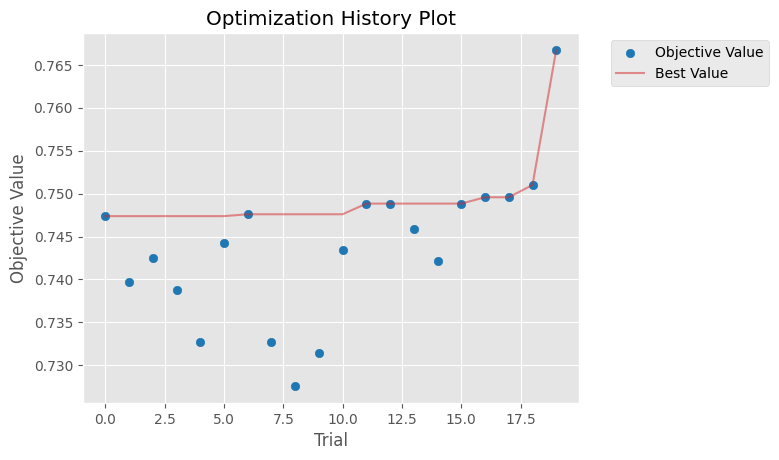

In [40]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_19708\1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

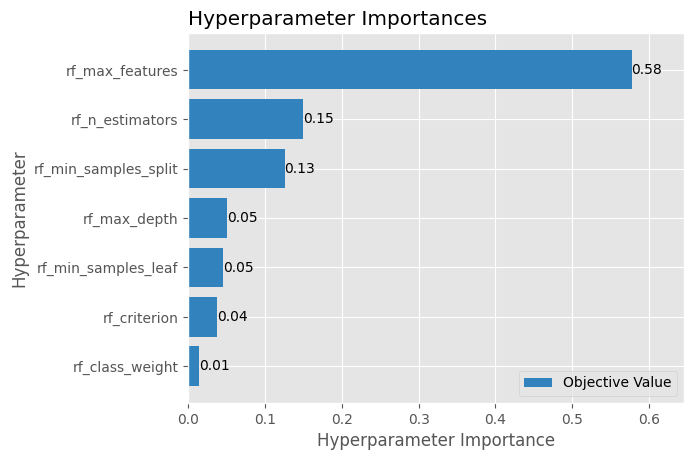

In [41]:
optuna.visualization.matplotlib.plot_param_importances(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_19708\3879122787.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(


array([<Axes: xlabel='rf_class_weight', ylabel='Objective Value'>,
       <Axes: xlabel='rf_criterion'>, <Axes: xlabel='rf_max_depth'>,
       <Axes: xlabel='rf_max_features'>,
       <Axes: xlabel='rf_min_samples_leaf'>,
       <Axes: xlabel='rf_min_samples_split'>,
       <Axes: xlabel='rf_n_estimators'>], dtype=object)

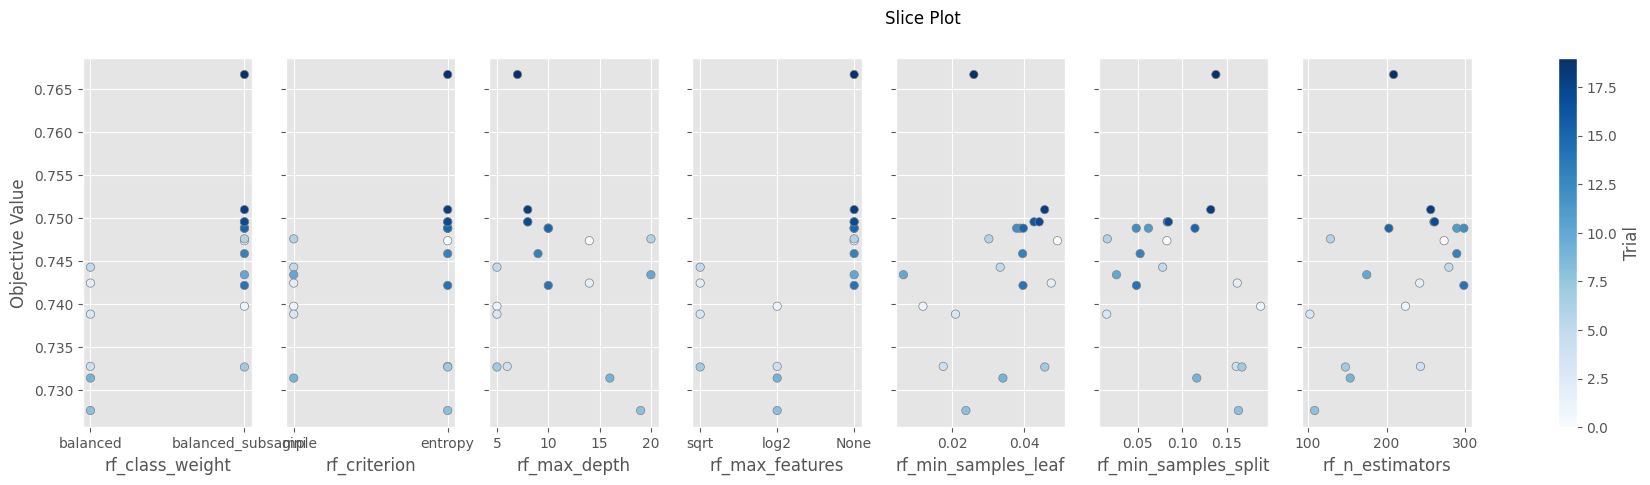

In [42]:
optuna.visualization.matplotlib.plot_slice(
    study,
    params=["rf_n_estimators", "rf_criterion", "rf_max_depth", 
            'rf_min_samples_split', 'rf_max_features', 'rf_min_samples_leaf',
            'rf_class_weight'],
)

C:\Users\steve\AppData\Local\Temp\ipykernel_19708\2601326980.py:1: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_edf([study])


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

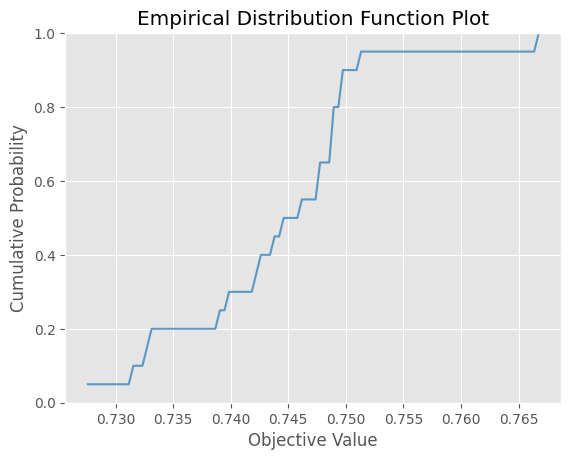

In [43]:
optuna.visualization.matplotlib.plot_edf([study])

## Classification

In [45]:
def run_model(classifier_name, sel_method, X_train, y_train):
        
        model = RandomForestClassifier(n_estimators=study.best_params["rf_n_estimators"], 
                                       criterion=study.best_params["rf_criterion"],
                                       max_depth=study.best_params["rf_max_depth"],
                                       min_samples_split=study.best_params["rf_min_samples_split"],
                                       max_features=study.best_params["rf_max_features"],
                                       min_samples_leaf=study.best_params["rf_min_samples_leaf"],
                                       random_state=42, 
                                       class_weight=study.best_params["rf_class_weight"])
        
        if sel_method == "Boruta":
                sel_method = "Boruta" 
        else: 
                sel_method = "Complete"
        
        skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=skf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": sel_method,
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": len(X_train.columns),
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [46]:
trained_rf_n, metrics_rf_n = run_model("Random Forest", "Complete", X_train_missForest_t, y_train)
trained_rf_t, metrics_rf_t = run_model("Random Forest", "Boruta", X_train_t, y_train)

In [47]:
from sklearn.utils import resample

def bootstrap_ci(model, X, y, metric_fn, n_iterations, ci=0.95, use_proba=False):
    scores = []
    n = len(X)
    for _ in range(n_iterations):
        X_resampled, y_resampled = resample(X, y, n_samples=n, stratify=y)
        try:
            y_pred = model.predict_proba(X_resampled) if use_proba else model.predict(X_resampled)
            score = metric_fn(y_resampled, y_pred)
            if not np.isnan(score):
                scores.append(score)
        except Exception:
            # Skip this bootstrap sample if error occurs (e.g. missing class for roc_auc)
            continue
    if len(scores) == 0:
        return (np.nan, np.nan)
    lower = np.percentile(scores, (1 - ci) / 2 * 100)
    upper = np.percentile(scores, (1 + ci) / 2 * 100)
    std_dev = np.std(scores)
    return round(lower, 3), round(upper, 3), round(std_dev, 3)

In [23]:
from sklearn.metrics import confusion_matrix

def compute_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = total - (tp + fp + fn)
    specificity = tn / (tn + fp)
    return round(np.nanmean(specificity), 3)

In [24]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        if isinstance(X_train, np.ndarray):
                columns = X_train.shape[1]
        else:
                columns = len(X_train.columns)        
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        # Calculate metrics
        metrics_train = {
                "accuracy": accuracy_score(y_train, pred_train),
                "balanced_accuracy": balanced_accuracy_score(y_train, pred_train),
                "precision_macro": precision_score(y_train, pred_train, average="macro", zero_division=0),
                "recall_macro": recall_score(y_train, pred_train, average="macro", zero_division=0),
                "f1_macro": f1_score(y_train, pred_train, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_train, pred_train_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_train, pred_train),
        }

        metrics_test = {
                "accuracy": accuracy_score(y_test, pred_test),
                "balanced_accuracy": balanced_accuracy_score(y_test, pred_test),
                "precision_macro": precision_score(y_test, pred_test, average="macro", zero_division=0),
                "recall_macro": recall_score(y_test, pred_test, average="macro", zero_division=0),
                "f1_macro": f1_score(y_test, pred_test, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_test, pred_test_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_test, pred_test),
        }
                
        elapsed_time = time.time() - start_time
        
        # Metric functions for bootstrap CI (exclude ROC AUC here)
        metric_fns = {
                "accuracy": accuracy_score,
                "balanced_accuracy": balanced_accuracy_score,
                "precision_macro": lambda yt, yp: precision_score(yt, yp, average="macro", zero_division=0),
                "recall_macro": lambda yt, yp: recall_score(yt, yp, average="macro", zero_division=0),
                "f1_macro": lambda yt, yp: f1_score(yt, yp, average="macro", zero_division=0),
                "roc_auc_macro": lambda yt, yp: roc_auc_score(yt, yp, average="macro", multi_class="ovr"),
                "specificity_macro": lambda yt, yp: compute_specificity(yt, yp),
        }

        # Bootstrap confidence intervals
        ci_test = {
                m: bootstrap_ci(
                model, X_test, y_test, fn,
                n_iterations=1000,
                use_proba=(m == "roc_auc_macro")
                )
                for m, fn in metric_fns.items()
        }

        # Separate CI bounds and std with clear variable names
        ci_bounds = []
        std_values = []
                
        for lower, upper, std in ci_test.values():
                ci_bounds.append(f"[{round(lower, 3)}, {round(upper, 3)}]")
                std_values.append(round(std, 3)) 
                
        # Round metric values
        train_rounded = [round(score, 3) for score in metrics_train.values()]
        test_rounded = [round(score, 3) for score in metrics_test.values()] 
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "Boruta",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": columns,
                "Metric": list(metrics_train.keys()),      
                "Train data": train_rounded,
                "Test data": test_rounded,
                "95% CI": ci_bounds,
                "Std Dev": std_values,
        })
        
        return pred_metrics_df

In [48]:
results = "all"
prediction_df_report = None

if results == "all":
    
    pred_rf_n = eval_model("Random Forest", trained_rf_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_rf_n, pred_rf_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":
    
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)
  
    prediction_df = pd.concat([pred_rf_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier    Classification Time Total Features Metric                          
Boruta            Random Forest 0.161               22             accuracy                0.828   
                                                                   balanced_accuracy       0.839   
                                                                   precision_macro         0.828   
                                                                   recall_macro            0.839   
                                                                   f1_macro                0.831   
                                                                   roc_auc_macro           0.953   
                                                                   specificity_macro       0.912   
                                0.195               9              accuracy                0.828   
                                                                   balanced_accuracy       0.839   
                                                                   precision_macro         0.828   
                                                                   recall_macro            0.839   
                                                                   f1_macro                0.831   
                                                                   roc_auc_macro           0.944   
                                                                   specificity_macro       0.912   

                                                                                      Test data  \
Feature Selection Classifier    Classification Time Total Features Metric                         
Boruta            Random Forest 0.161               22             accuracy               0.715   
                                                                   balanced_accuracy      0.721   
                                                                   precision_macro        0.708   
                                                                   recall_macro           0.721   
                                                                   f1_macro               0.712   
                                                                   roc_auc_macro          0.894   
                                                                   specificity_macro      0.857   
                                0.195               9              accuracy               0.741   
                                                                   balanced_accuracy      0.745   
                                                                   precision_macro        0.735   
                                                                   recall_macro           0.745   
                                                                   f1_macro               0.737   
                                                                   roc_auc_macro          0.903   
                                                                   specificity_macro      0.869   

                                                                                              95% CI  \
Feature Selection Classifier    Classification Time Total Features Metric                              
Boruta            Random Forest 0.161               22             accuracy           [0.646, 0.778]   
                                                                   balanced_accuracy  [0.659, 0.788]   
                                                                   precision_macro    [0.637, 0.782]   
                                                                   recall_macro       [0.657, 0.781]   
                                                                   f1_macro           [0.645, 0.779]   
                                                                   roc_auc_macro      [0.856, 0.928]   
                                                                   s

### Export model

In [49]:
trained_rf_t

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=7, max_features=None,
                       min_samples_leaf=0.026057537850307663,
                       min_samples_split=0.1380134599246233, n_estimators=209,
                       random_state=42)

In [50]:
import pickle

with open("rf_model.pkl", "wb") as file:
    pickle.dump(trained_rf_t, file)
    
print("Random Forest model saved successfully!")

Random Forest model saved successfully!
